In [1]:
import sirf.STIR as STIR
import brainweb
from tqdm.auto import tqdm
import numpy
import os
import cil.optimisation.algorithms as algorithms
import cil.optimisation.functions as functions
import cil.optimisation.operators as operators

In [2]:
dir = os.path.dirname("minimal.ipynb")
msg = STIR.MessageRedirector(dir+"/info.txt", dir+"/warnings.txt", dir+"/error.txt")

In [3]:
fname, url= sorted(brainweb.utils.LINKS.items())[0]
files = brainweb.get_file(fname, url, ".")
data = brainweb.load_file(fname)

brainweb.seed(1337)

In [4]:
for f in tqdm([fname], desc="mMR ground truths", unit="subject"):
    vol = brainweb.get_mmr_fromfile(f, petNoise=1, t1Noise=0.75, t2Noise=0.75, petSigma=1, t1Sigma=1, t2Sigma=1)
fdg_arr = vol['PET']

mMR ground truths:   0%|          | 0/1 [00:00<?, ?subject/s]

In [5]:
# Select central slice
central_slice = fdg_arr.shape[0]//2
fdg_arr = fdg_arr[central_slice, :, :]

# Select a central ROI with 120x120
idim = [120,120]
offset = (numpy.array(fdg_arr.shape) - numpy.array(idim)) // 2
fdg_arr = fdg_arr[offset[0]:offset[0]+idim[0], offset[1]:offset[1]+idim[1]]

# Now we make sure our image is of shape (1, 120, 120) 
fdg_arr = fdg_arr[numpy.newaxis,...]

In [6]:
templ_sino = STIR.AcquisitionData("template_sinogram.hs") # create an empty sinogram using a template

In [7]:
im = STIR.ImageData(templ_sino)
dim = fdg_arr.shape
voxel_size=im.voxel_sizes()
im.initialise(dim,(voxel_size[0]*2, voxel_size[1], voxel_size[2]))
fdg = im.clone().fill(fdg_arr)

In [8]:
acq_model_matrix = STIR.SPECTUBMatrix()
acq_model_matrix.set_resolution_model(0,0,full_3D=False)
am = STIR.AcquisitionModelUsingMatrix(acq_model_matrix)
am.set_up(templ_sino, fdg)

In [9]:
sino = am.forward(fdg)

no additive term added
no unnormalisation applied
no background term added


In [10]:
bp = am.backward(sino)

backprojecting...ok


In [11]:
sino = am.forward(bp)

no additive term added
no unnormalisation applied
no background term added


In [12]:
bp = am.backward(sino)

backprojecting...ok


In [13]:
sino = am.forward(bp)

no additive term added
no unnormalisation applied
no background term added


In [14]:
sino = am.forward(fdg)
bp = am.backward(sino)
sino = am.forward(bp)
bp = am.backward(sino)

no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok


You may need to close Figure 1 window to continue...


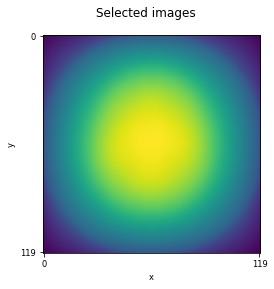

In [15]:
bp.show()

In [16]:
sino = am.forward(fdg)

no additive term added
no unnormalisation applied
no background term added


In [17]:
bp = am.backward(sino)

backprojecting...ok


In [18]:
obj_fun = STIR.make_Poisson_loglikelihood(sino)
obj_fun.set_acquisition_model(am)

reconstructor = STIR.OSMAPOSLReconstructor()
reconstructor.set_objective_function(obj_fun)
reconstructor.set_num_subsets(21)
reconstructor.set_num_subiterations(42)
reconstructor.set_up(bp)

reconstructor.reconstruct(bp)

Total CPU Time 0.43secs


In [19]:
tmp = am.forward(fdg)

no additive term added
no unnormalisation applied
no background term added


In [20]:
grad = operators.GradientOperator(fdg)

Initialised GradientOperator with numpy backend


In [21]:
### fails ###
tmp = am.forward(fdg)

no additive term added
no unnormalisation applied
no background term added
